## Shashank Karyakarte

## CE677B HA2.

### Roll No: 20103107

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd

#### Given .o and .n files were read in matlab and pseudoranges and satellite coordinates data was exported in exel sheet attached in this submission.

#### This data contains pseudo ranges at 98646 epochs with time difference of 0.5 seconds between successive epochs.

#### At every epoch, number of satellite that has measured pseudo ranges are different thus a dynamic code is written that fetches all the available pseudo ranges at that particular epoch from .o file.

#### This code then also fetches coordinates of only those satellites that has given pseudo-ranges at that epoch and uses them in measurement model.

#### Dimensions of $H_k$ and $R_{k}$ matrix are adjusted at every epoch $H_k$ being n\times 7 and $R_{k}$ being n X n according to number of pseudo ranges available at that particular epoch and a code is written to calculate these matrices at every epoch.

## Observations file:

In [2]:
df1 = pd.read_excel('Obs_file_data.xlsx')
df1

,GPS Week,Time of Week,Satellite PRN,Pseudo-range
0,1688,464528.0,10,2.163416e+07
1,1688,464528.0,5,2.223411e+07
2,1688,464528.0,7,2.171536e+07
3,1688,464528.0,8,2.260458e+07
4,1688,464528.0,4,2.498387e+07
...,...,...,...,...
98641,1688,470947.5,5,2.097395e+07
98642,1688,470947.5,21,2.449762e+07
98643,1688,470947.5,7,2.318338e+07
98644,1688,470947.5,8,2.077676e+07


### Navigation file data:

In [6]:
df2 = pd.read_excel('Mysatellites.xls')
df2

,S5,S8,S13,S4,S10,S7,S16,S23,S2,S26,S28,S21,S15
0,-2.218337e+06,1.459498e+07,2.521664e+07,6.688152e+06,9.839039e+06,2.239647e+07,7.268879e+05,2.093431e+07,-6.590935e+06,-8.097550e+05,1.156891e+07,-2.110363e+07,-1.541201e+07
1,-2.584494e+07,-5.903658e+06,-4.812328e+06,-1.420181e+07,-2.170970e+07,4.039982e+06,2.585705e+07,2.710492e+06,-1.934753e+07,-1.550404e+07,-1.892193e+07,7.117217e+04,-8.284448e+06
2,-5.411265e+06,-2.143290e+07,6.866028e+06,2.115634e+07,1.104013e+07,-1.388504e+07,-5.216304e+06,1.637644e+07,1.734863e+07,-2.212481e+07,-1.389444e+07,-1.596936e+07,-2.004469e+07


In [7]:
import sympy as sym
sym.init_printing()
from sympy import *

xi, yi, zi, vx, vy, vz, xi_1, yi_1 = sym.symbols('xi yi zi vx vy vz xi_1 yi_1')

wx, wy, wz, br, w_b, w_vx, w_vy, w_vz = sym.symbols('wx wy wz br w_b w_vx w_vy w_vz')

Funcrions are defined for process model as explained in report. Note here $\Delta t= 0.5sec$.

In [8]:
f1= xi+ (vx*0.5) + wx
f2= yi+ (vy*0.5) + wy
f3= zi+ (vz*0.5) + wz
f4= vx+ (w_vx)
f5= vy+ (w_vy)
f6=vz+ (w_vz)
f7=br+ w_b


Following function is defined to calculate state vector at each iteration.

### Fk matrix: 
state transition matrix is calculated by differentiating each function by state vector's each element as follows:

In [9]:
F_k= Matrix([[sym.diff(f1,xi),sym.diff(f1,yi),sym.diff(f1,zi),sym.diff(f1,vx),sym.diff(f1,vy),sym.diff(f1,vz),sym.diff(f1,br)],
             [sym.diff(f2,xi),sym.diff(f2,yi),sym.diff(f2,zi),sym.diff(f2,vx),sym.diff(f2,vy),sym.diff(f2,vz),sym.diff(f2,br)],
             [sym.diff(f3,xi),sym.diff(f3,yi),sym.diff(f3,zi),sym.diff(f3,vx),sym.diff(f3,vy),sym.diff(f3,vz),sym.diff(f3,br)],
             [sym.diff(f4,xi),sym.diff(f4,yi),sym.diff(f4,zi),sym.diff(f4,vx),sym.diff(f4,vy),sym.diff(f4,vz),sym.diff(f4,br)],
             [sym.diff(f5,xi),sym.diff(f5,yi),sym.diff(f5,zi),sym.diff(f5,vx),sym.diff(f5,vy),sym.diff(f5,vz),sym.diff(f5,br)],
             [sym.diff(f6,xi),sym.diff(f6,yi),sym.diff(f6,zi),sym.diff(f6,vx),sym.diff(f6,vy),sym.diff(f6,vz),sym.diff(f6,br)],
             [sym.diff(f7,xi),sym.diff(f7,yi),sym.diff(f7,zi),sym.diff(f7,vx),sym.diff(f7,vy),sym.diff(f7,vz),sym.diff(f7,br)]])

F_k

⎡1  0  0  0.5   0    0   0⎤
⎢                         ⎥
⎢0  1  0   0   0.5   0   0⎥
⎢                         ⎥
⎢0  0  1   0    0   0.5  0⎥
⎢                         ⎥
⎢0  0  0   1    0    0   0⎥
⎢                         ⎥
⎢0  0  0   0    1    0   0⎥
⎢                         ⎥
⎢0  0  0   0    0    1   0⎥
⎢                         ⎥
⎣0  0  0   0    0    0   1⎦

### Initialization of state vector:
State vector is initiated by calculating X and Y and Z coordinate of initial point by using least squared adjustment as discussed in report.

In [10]:
Xinitial=Matrix([[3520414.8414152],[-3534467.07226563],[-1807807.43145721],[0],[0],[0],[-924552.6951]])

### Initialization of variance covariance matrix of state vector:

In [11]:
Pkinitial=zeros(7,7)
for i in range (0,7):
    Pkinitial[i,i]=25
Pkinitial
Pkinitial[3,3]=1
Pkinitial[4,4]=1
Pkinitial[5,5]=1
Pkinitial

⎡25  0   0   0  0  0  0 ⎤
⎢                       ⎥
⎢0   25  0   0  0  0  0 ⎥
⎢                       ⎥
⎢0   0   25  0  0  0  0 ⎥
⎢                       ⎥
⎢0   0   0   1  0  0  0 ⎥
⎢                       ⎥
⎢0   0   0   0  1  0  0 ⎥
⎢                       ⎥
⎢0   0   0   0  0  1  0 ⎥
⎢                       ⎥
⎣0   0   0   0  0  0  25⎦

### Generation of process error matrix wk at each epoch:
Random numbers with mean zero and standard deviation 1 are generated, this then used to generate error matrix at each epoch using function defined below.

In [13]:
def return_Wk_mat():
    NN=np.random.normal(0.0, 1.0,size=7)
    W_Kmat= zeros(7,1)
    
    for i in range (0,7):
        W_Kmat[i,0]= NN[i]
    
    return W_Kmat

### Dynamic model  (prediction function):
following function is defined to implement dynamic model as discussed in lab report.

In [14]:
def Dynamic_model(Xinitial,F_k,Pkinitial):
    W_Kmat=return_Wk_mat()
    Xupdated=((F_k*Xinitial)+W_Kmat)
    
    
    
    #Q= (W_Kmat*(W_Kmat.T))
    
    Q= 0.01*(eye(7))
    
    Pupdated= (F_k*(Pkinitial)*(F_k.T))+ Q
    
    return Xupdated,Pupdated

This function returns predicted value of state vector and its covariance matrix at each epoch.

Following sympy expressions are defined to for construction of measurement model as discussed in report:

In [15]:

x_k, y_k, z_k, X, Y, Z, v_ = sym.symbols('x_k y_k z_k X Y Z v_')


In [16]:
D=((((x_k-(X))**2)+((y_k-(Y))**2)+((z_k-(Z))**2))**0.5)+v_

Following function is written to fetch a dataframe at every epoch that contains pseudo range information from df1 at that particular epoch. Size of this dataframe corresponds to number of satellites available at that epoch.

In [17]:
def get_df_corresponding_to_current_epoch(df1,TOW):
    
    newdf = df1[(df1['Time of Week']==TOW)]
    newdf=newdf.reset_index()
    jj=newdf.shape[0]
    
    return newdf,jj

### Zk matrix: matrix of measurements.
This matrix is computed at every iteration by using following function by substituting Xk vector obtained in prediction stage in above expression.

In [18]:
def calc_Zkmatrix(Xk,V_Kmat,newdf,jj,df2):
    
    Zkpred=zeros(jj,1)
    
    for i in range (0,jj):
        sat=newdf['Satellite PRN'][i]
        sample=f'S{sat}'
    
        Zkpred[i,0]=D.subs([(x_k,Xk[0,0]),(y_k,Xk[1,0]),(z_k,Xk[2,0]),(v_,V_Kmat[i,0]),(X,df2[sample][0]),(Y,df2[sample][1]),(Z,df2[sample][2])])
 
    return Zkpred
    

### Hk matrix: by partially differentiating measurement functions w.r.t. parameter matrix.
Following function is defined to calculate Hk matrix at every iteration as discussed in report.

In [19]:
def calc_Hkmatrix(Xk,V_Kmat,newdf,jj,df2):
    Hk=zeros(jj,7)
    
    for i in range (0,jj):
        sat=newdf['Satellite PRN'][i]
        sample=f'S{sat}'
        
        
        
        for kk in range (0,7):
            
            if kk==0:
                Hk[i,kk]=sym.diff(D,x_k).subs([(x_k,Xk[0,0]),(y_k,Xk[1,0]),(z_k,Xk[2,0]),(X,df2[sample][0]),(Y,df2[sample][1]),(Z,df2[sample][2])])
            
            if kk==1:
                Hk[i,kk]=sym.diff(D,y_k).subs([(x_k,Xk[0,0]),(y_k,Xk[1,0]),(z_k,Xk[2,0]),(X,df2[sample][0]),(Y,df2[sample][1]),(Z,df2[sample][2])])

            if kk==2:
                Hk[i,kk]=sym.diff(D,z_k).subs([(x_k,Xk[0,0]),(y_k,Xk[1,0]),(z_k,Xk[2,0]),(X,df2[sample][0]),(Y,df2[sample][1]),(Z,df2[sample][2])])

     
            if kk==3:
                Hk[i,kk]=0
                
            if kk==4:
                Hk[i,kk]=0
                
            if kk==5:
                Hk[i,kk]=0
                
            if kk==6:
                Hk[i,kk]=1
                
    return Hk       

            
            

### Rk matrix initialization:
It is initialized by assuming values of standard deviation as discussed in report.

In [20]:
def get_Rk_mat(jj):
    
    Rk= zeros(jj,jj)
    
    for i in range (0,jj):
        Rk[i,i]=25
        
    return Rk

### Generation of matrix of measurement errors Vk:
Random numbers with mean zero and standard deviation 0.1 are generated, this then used to generate error matrix at each epoch using function defined below.


In [21]:
def return_Vk_mat(jj):
    
    NN2=np.random.normal(0.0, 1.0,size=jj)
    
    V_Kmat= zeros(jj,1)
    for i in range (0,jj):
        V_Kmat[i,0]= NN2[i]
    
   
    
    return V_Kmat

Following function is defined to generate matrix of observed measurements from four stationary points at every epoch using data in dataframe df2 imported above.

In [22]:
def get_Zk_mat(newdf,jj):
    
    Zk= zeros(jj,1)
    for i in range (0,jj):
        Zk[i,0]= newdf['Pseudo-range'][i]
        
    
    return Zk

## Measurement model:
Following function is defined that acts as corrector in EKF and corrects predicted values of state vector , its covariance matrix at each pass in EKF.

In [34]:
def Measurement_model(Xupdated,Pupdated,TOW,df1,df2):
    
    newdf,jj=get_df_corresponding_to_current_epoch(df1,TOW)
    
    V_Kmat=return_Vk_mat(jj)
    
    Hk_mat=calc_Hkmatrix(Xupdated,V_Kmat,newdf,jj,df2)
    
    Rk=get_Rk_mat(jj)
    
    KK= (Pupdated*(Hk_mat.T))*(((Hk_mat*(Pupdated)*(Hk_mat.T))+(Rk))**-1)
    
    temp1= (eye(7)-(KK*Hk_mat))
    
    Pupdated_more=(temp1*Pupdated*(temp1.T))+(KK*Rk*KK.T)
    
    #print(jj)
    Zk=get_Zk_mat(newdf,jj)
    
    Zkpred=calc_Zkmatrix(Xupdated,V_Kmat,newdf,jj,df2)
    
    Xupdated_more= Xupdated+(KK*(Zk-Zkpred))
    
    print("completed")
    
    return Xupdated_more,Pupdated_more
    

Following function is defined to append trace of covariance matrix of state vector at each iteration to store it in another matrix.

In [36]:
def trace_of_Pk(Pmat,q,tracematrix):
    tracematrix[q,0]=(Pmat[0,0]+Pmat[1,1]+Pmat[2,2]+Pmat[3,3]+Pmat[4,4]+Pmat[5,5]+Pmat[6,6])
    return tracematrix
    
    

## Extended Kalman Filter:

### All the above defined functions are compiled here as required to iterate and update state vector and its covariance matrix over time epoch 0 to 20 sec:

In [37]:
tracematrix_= zeros(12839,1)
time= np.arange(0,12839,1)
X_Vect=zeros(12839,1)
Y_Vect=zeros(12839,1)
Z_Vect=zeros(12839,1)
Vx_Vect=zeros(12839,1)
Vy_Vect=zeros(12839,1)
Vz_Vect=zeros(12839,1)
CE_Vect=zeros(12839,1)
TOW=464528.0


for q in range (0,12839):
    
    # call dynamic model
    Xupdated,Pupdated = Dynamic_model(Xinitial,F_k,Pkinitial)
    
    #Zk=get_Zk_mat(df2,i)
    
    # call to measurement model
    Xupdated_more,Pupdated_more=Measurement_model(Xupdated,Pupdated,TOW,df1,df2)
    
    TOW=TOW+0.5
    #print("yes1")
    # saving trajectory information to another vectors.
    X_Vect[q,0]=Xupdated_more[0,0]
    #print("yes2")
    Y_Vect[q,0]=Xupdated_more[1,0]
    #print("yes3")
    Z_Vect[q,0]=Xupdated_more[2,0]
    #print("yes4")
    Vx_Vect[q,0]=Xupdated_more[3,0]
    #print("yes5")
    Vy_Vect[q,0]=Xupdated_more[4,0]
    #print("yes6")
    Vz_Vect[q,0]=Xupdated_more[5,0]
    #print("yes7")
    CE_Vect[q,0]=Xupdated_more[6,0]
    #print("yes8")
    
    #print(q)    
    # Calculating trace of Pk matrix:
    tracematrix_=trace_of_Pk(Pupdated_more,q,tracematrix_)
    #print(q)
    # updating state vector and its covariance matrix at every iteration.
    Xinitial=Xupdated_more
    
    Pkinitial=Pupdated_more
    
    # This function prints 'completed' aif calculation at that particular epoch are completed.
    
    
    
    
    
    

completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed
completed


KeyError: 'S29'

### Plot of trajectory so obtained:

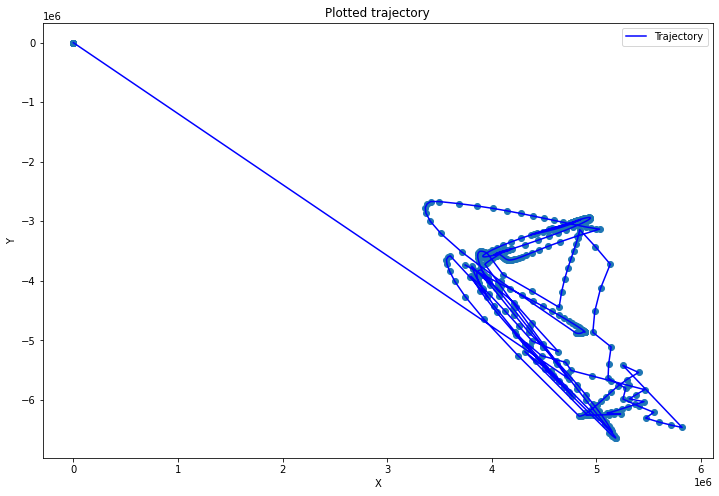

In [38]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(X_Vect, Y_Vect, color="blue",label="Trajectory") # half-transparant
#ax.plot(Df3['T'], Df3['Ay'], color="#FF8C00",label="Ay")        # RGB hex code
plt.scatter(X_Vect, Y_Vect) 
ax.set_title("Plotted trajectory")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()

### Plot of trace of variance covariance matrix of state vector.

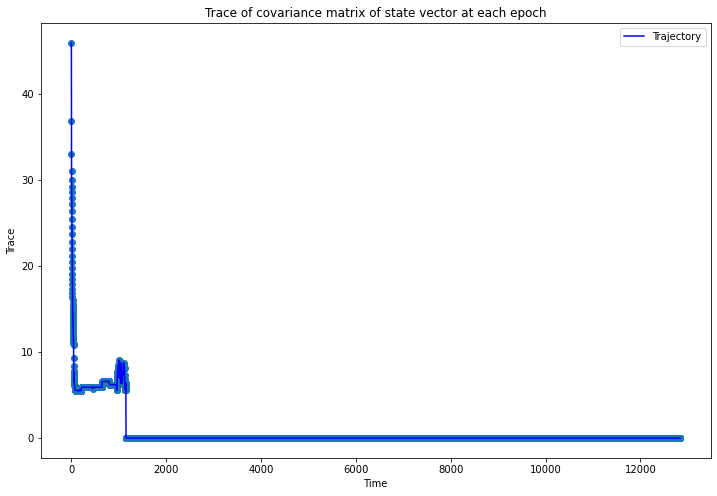

In [39]:
fig, ax2 = plt.subplots(figsize=(12,8))

ax2.plot(time, tracematrix_, color="blue",label="Trajectory") # half-transparant
#ax.plot(Df3['T'], Df3['Ay'], color="#FF8C00",label="Ay")        # RGB hex code
plt.scatter(time, tracematrix_) 
ax2.set_title("Trace of covariance matrix of state vector at each epoch")
ax2.set_xlabel("Time")
ax2.set_ylabel("Trace")
ax2.legend()

### Appending all trajectory iformation in one dtatframe and exporting.

In [ ]:
Z_Vect=zeros(12839,1)
Vx_Vect=zeros(12839,1)
Vy_Vect=zeros(12839,1)
Vz_Vect=zeros(12839,1)
CE_Vect=zeros(12839,1)

In [40]:
time=list(time)
X_Vect=list(X_Vect)
Y_Vect=list(Y_Vect)
Z_Vect=list(Z_Vect)
Vx_Vect=list(Vx_Vect)
Vy_Vect=list(Vy_Vect)
Vz_Vect=list(Vz_Vect)
CE_Vect=list(CE_Vect)
tracematrix_=list(tracematrix_)

#df3= pd.DataFrame(X_Vect,Y_Vect,)
df3=pd.DataFrame(list(zip(time,X_Vect, Y_Vect,Z_Vect,Vx_Vect,Vy_Vect,Vz_Vect,CE_Vect,tracematrix_)),
               columns =['time','X', 'Y', 'Z','Vx','Vy','Vz','Clock Error','trace of Pk matrix'])
df3.to_excel('HA2trajectory.xlsx')
df3

,time,X,Y,Z,Vx,Vy,Vz,Clock Error,trace of Pk matrix
0,0,3746843.43679784,-3735759.39619299,-1817627.29111408,4480.00783533390,-3984.56106379802,-195.314010064418,-1583481.60081425,45.9224890311401
1,1,3821159.80423576,-3808681.77212795,-1830234.02065013,23687.4630833442,-20633.6601210529,1201.21772740253,-1894889.11015230,36.8265922724264
2,2,3883667.12285710,-3868718.25188861,-1837097.54362801,55238.6739383681,-47766.6666922115,3758.81720674556,-2096839.00078277,32.9712991262873
3,3,3962723.86966865,-3941979.21009276,-1841298.83610425,94967.2570373988,-81887.4639842795,6276.95980532669,-2241141.33338743,31.0272996498302
4,4,4062360.99437581,-4032819.17758064,-1845260.49665529,136926.074083576,-118106.191154987,7387.30776501009,-2349749.44276859,29.9390304225668
...,...,...,...,...,...,...,...,...,...
12834,12834,0,0,0,0,0,0,0,0
12835,12835,0,0,0,0,0,0,0,0
12836,12836,0,0,0,0,0,0,0,0
12837,12837,0,0,0,0,0,0,0,0
